In [1]:
# This notebook illustrates Transfer Learning. It uses a pre-trained model
# and fine-tunes it to work for classifying dogs and cats.
# This uses the PyTorch Transfer Learning tutorial, and adopts it to the
# dogs vs cats dataset.
# http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [32]:
# Transforms are common image transforms. The compose function can be used to
# chain together multiple transforms.
# (1) RandomResizedCrop: It creates a crop of random size (8-100% of orignal),
#     changes the aspect ratio randomly, and then resizes to the original size.
# (2) RandomHorizontalFlip: It flips the image horizontally with a given
#     probability (default of 0.5)
# (3) ToTensor: Converts a PIL image or numpy array (H,W,C) in the range [0,255]
#     to a torch.FloatTensor of shape (C,H,W) and range [0, 1]
# (4) Normalize: Given means and stddev of each channel of the input, it will
#     normalize each channel as x = (x - mean)/stddev.

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.25,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../Data/dogscats'
# datasets.ImageFolder is used to load image data. It assumes images are 
# arranged like: "root/dog/dog1.png", where root is the path of train or
# valid folders, dog is a class index. It applies given transforms to images 
# while loading. It returns a tuple of (images (list), classes (list)).
# Access the lists using: image_datasets['train'].imgs and .classes
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
# DataLoader: It combines a Dataset and a Sampler, and returns a single or
# multi-process iterator over the dataset.
# Source: https://github.com/pytorch/pytorch/blob/master/torch/utils/data/dataloader.py
# (1) batch-size: how many samples are loaded per batch
# (2) shuffle: shuffles the dataset for each epoch (only used at train time)
# (3) num_workers: how many subprocesses to use for data loading

# (1) The iterator returned by DataLoader can be accessed using the 'iter'
#     method.
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [33]:
print(type(image_datasets))
print(type(image_datasets['train']))
print(image_datasets['train'].classes)
print(type(image_datasets['train'].imgs))
print(len(image_datasets['train'].imgs))
print(image_datasets['train'].__len__())
print(len(image_datasets['valid']))
print(type(dataloaders['train']))
print(type(iter(dataloaders['train'])))

<class 'dict'>
<class 'torchvision.datasets.folder.ImageFolder'>
['cats', 'dogs']
<class 'list'>
240
240
140
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoaderIter'>


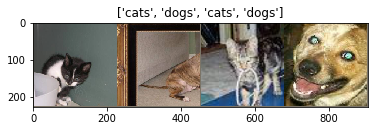

In [34]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs_batch_1, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs_batch_1, nrow=4)

imshow(out, title=[class_names[x] for x in classes])

In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                # A Variable represents a node in a computation graph.
                # If x is a Variable. x.data is a tensor, and x.grad is a Variable
                # which holds gradient of x w.r.t some scalar value.
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [36]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['valid']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

In [42]:
model_conv = torchvision.models.resnet18(pretrained=True)
# Each Variable has a flag 'required_grad' which can be used
# to exclude that Variable's subgraph from gradient computation.
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# in_features is the size of each input sample coming into the last layer of Resnet18.
# We set the last layer of the resnet18 model to a new fully connected layer with
# 2 outputs.
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# To construct an Optimizer, we need to give it an iterable containing
# the parameters to optimize. All parameters should be Variables.
# Observe that only parameters of final layer are being optimized as
# opoosed to before.
#optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.fc.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [43]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5604 Acc: 0.7208
valid Loss: 0.2605 Acc: 0.9286

Epoch 1/9
----------
train Loss: 0.3667 Acc: 0.8500
valid Loss: 0.1820 Acc: 0.9214

Epoch 2/9
----------
train Loss: 0.3830 Acc: 0.8292
valid Loss: 0.1307 Acc: 0.9643

Epoch 3/9
----------
train Loss: 0.4240 Acc: 0.8250
valid Loss: 0.2346 Acc: 0.9000

Epoch 4/9
----------
train Loss: 0.3562 Acc: 0.8292
valid Loss: 0.1184 Acc: 0.9500

Epoch 5/9
----------
train Loss: 0.3525 Acc: 0.8125
valid Loss: 0.1018 Acc: 0.9714

Epoch 6/9
----------
train Loss: 0.3812 Acc: 0.8292
valid Loss: 0.1101 Acc: 0.9714

Epoch 7/9
----------
train Loss: 0.3362 Acc: 0.8667
valid Loss: 0.1023 Acc: 0.9786

Epoch 8/9
----------
train Loss: 0.3611 Acc: 0.8250
valid Loss: 0.1066 Acc: 0.9714

Epoch 9/9
----------
train Loss: 0.2455 Acc: 0.8958
valid Loss: 0.1021 Acc: 0.9714

Training complete in 15m 28s
Best val Acc: 0.978571


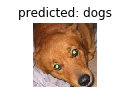

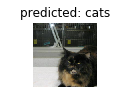

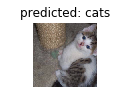

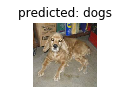

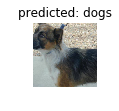

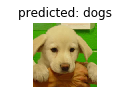

In [44]:
visualize_model(model_conv)

plt.ioff()
plt.show()